In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import os
from model import model_builder
import lightnet as ln
from test_script import test_step
from utils import plot_result, draw_bounding_boxes, mean_average_precision, to_pixel_coords, to_xyxy_coords, load_config
from lightnet.util import iou_cwh, iou_tlwh
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config("configs/train_anyv2_wizard.yaml")


BASE_DIR = config["base_dir"]
TRAIN_IMG_DIR = config["train_img_dir"]
TRAIN_DEPTH_DIR = config["train_depth_dir"]
TRAIN_LABEL_DIR =  config["train_label_dir"]
BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]
LEARNING_RATE = config["learning_rate"]
NUM_EPOCHS = config["num_epochs"]
MODEL_TYPE = config["model_type"]
FUSE_LAYER = config["fuse_layer"]
DATASET_NAME = config["dataset_name"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

TRAIN_IMG_DIR =  BASE_DIR + TRAIN_IMG_DIR
TRAIN_DEPTH_DIR = BASE_DIR + TRAIN_DEPTH_DIR
TRAIN_LABEL_DIR = BASE_DIR + TRAIN_LABEL_DIR

In [3]:
print(config)
print(f"Using Device {DEVICE}")

# model = ln.models.YoloV2(NUM_CLASSES)
# model.load('models/5_epochs_split.pt', strict=False)
# model.to(DEVICE)

model = model_builder(num_classes=NUM_CLASSES, model_type=MODEL_TYPE, fuse_layer=FUSE_LAYER)
model.load("models/anythingv2_best.pth")
model.to("cpu")

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir="data/image_splits/test/images",
    depth_dir="data/Depth_anything_v2/test/depth",
    labels_dir="data/image_splits/test/labels",
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
    model_type=MODEL_TYPE
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

{'dataset_name': 'anythingv2', 'base_dir': '/home/gkmo/workspace/data', 'train_img_dir': '/image_splits/train/images', 'train_depth_dir': '/Depth_anything_v2/train/depth', 'train_label_dir': '/image_splits/train/labels', 'batch_size': 16, 'num_workers': 16, 'learning_rate': 0.01, 'num_epochs': 500, 'device': 'cuda', 'model_type': 'rgbd', 'fuse_layer': 15}
Using Device cuda
Weights equivalent


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [4]:
do_test = False
if do_test:
    metric_map, test_loss, pred_boxes, true_boxes = test_step(
        model=model,
        dataloader=test_dataloader,
        batch_size=BATCH_SIZE,
        loss_fn=loss_fn,
        device=DEVICE
    )
    print(metric_map)

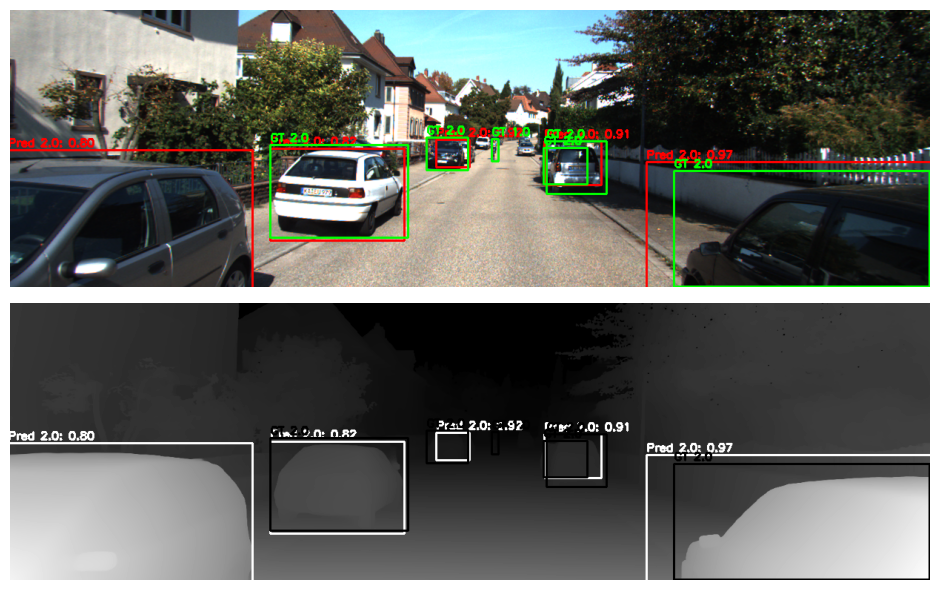

In [9]:
plot_result(model=model, test_dataset=test_dataset, index=3)